In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.gumbel import Gumbel
import math
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class BanditEnvironment:
  def __init__(self, k, device=torch.device('cpu')):
    self.Qs = torch.normal(0.0, 1.0, size=(k,), device=device)
    self.Ns = torch.zeros(k, device=device)

  def simulate(self, action_indices, n, increment_visits=True):
    repeated_action_indices = action_indices.repeat(n, 1)
    qs = torch.normal(self.Qs[repeated_action_indices], 1).mean(dim=0)
    if increment_visits:
      self.Ns[action_indices] += n
    return qs

In [3]:
class PolicyNetwork(nn.Module):
  def __init__(self, input_size, output_size, hidden_size=32, device=torch.device('cpu')):
    super().__init__()
    self.relu = nn.ReLU()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, output_size)

    self.to(device)

  def forward(self, xs):
    logits = self.relu(self.l1(xs))
    logits = self.l2(logits)
    return logits

In [4]:
class GumbelAgent:
  def __init__(self, k, device=torch.device('cpu')):
    self.k = k
    self.device = device
    # the input to the policy network is not relevant
    # since the environment is static
    state_size = 1
    self.policy_network = PolicyNetwork(state_size, k, device=device)
    self.state = torch.ones(1, dtype=torch.float32, device=device)
    self.gumbel = Gumbel(0, 1)

  def get_logits(self):
    return self.policy_network(self.state)

  def get_gumbel_sample(self):
    return torch.tensor([self.gumbel.sample() for _ in range(self.k)], device=self.device)

In [5]:
class GumbelPolicyImprovement:
  def __init__(self, env, agent, k, m, n, c_visit=50, c_scale=1):
    self.env = env
    self.agent = agent

    self.m = m
    self.n = n

    self.sh_steps = int(math.log2(m))
    self.sh_step_sims = self.n // self.sh_steps

    self.c_visit = c_visit
    self.c_scale = c_scale

  def sigma(self, qs):
    return (self.c_visit + torch.max(env.Ns)) * self.c_scale * qs

  def sequential_halving(self):
    logits = self.agent.get_logits()
    gumbel_sample = self.agent.get_gumbel_sample()
    _, action_indices = torch.sort(logits + gumbel_sample, descending=True)[:self.m]

    for step in range(1, self.sh_steps + 1):
      logits = self.agent.get_logits()
      gumbel_sample = self.agent.get_gumbel_sample()
      qs = self.env.simulate(action_indices, self.sh_step_sims)
      scores = logits[action_indices] + gumbel_sample[action_indices] + self.sigma(qs)

      _, relative_action_indices = torch.sort(scores, descending=True)
      relative_action_indices = relative_action_indices[:self.m // (2**step)]
      action_indices = action_indices[relative_action_indices]
    
    return action_indices

In [6]:
k, m, n = 60, 20, 20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
env = BanditEnvironment(k, device=device)
agent = GumbelAgent(k, device=device)
gumbel_policy_improvement = GumbelPolicyImprovement(env, agent, k, m, n) 

cpu


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(agent.policy_network.parameters(), lr=0.001, weight_decay=1e-4)

In [8]:
training_steps, batch_size = 1600, 32
As = deque(maxlen=2*batch_size)
losses, avg_rewards = [], [0.0]
for _ in tqdm(range(training_steps)):
  A = gumbel_policy_improvement.sequential_halving()
  reward = env.simulate(A, n, increment_visits=False)
  new_avg_reward = avg_rewards[-1] + (reward - avg_rewards[-1]) / len(avg_rewards)
  avg_rewards.append(new_avg_reward.cpu().item())
  As.append(A)
  if len(As) >= batch_size:
    optimizer.zero_grad()
    inputs = gumbel_policy_improvement.agent.state.repeat(len(As), 1)
    preds = gumbel_policy_improvement.agent.policy_network(inputs)
    loss = loss_fn(preds, torch.tensor(As, device=preds.device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

100%|███████████████████████████████████████| 1600/1600 [00:22<00:00, 70.86it/s]


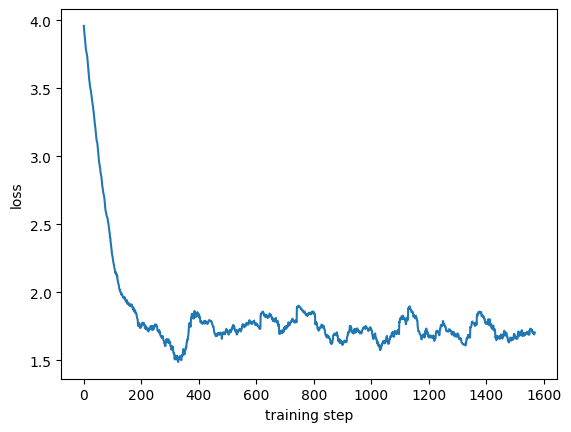

In [9]:
plt.plot(losses)
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

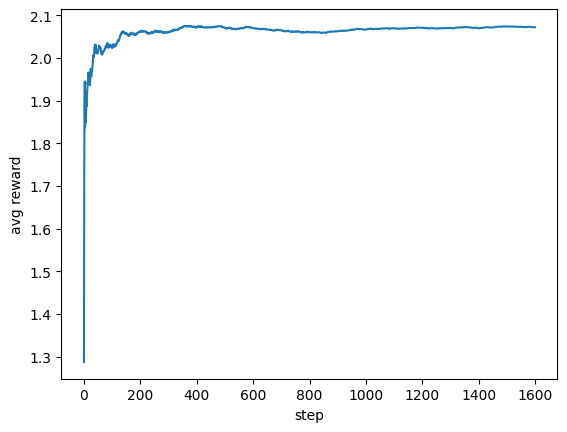

In [13]:
plt.plot(avg_rewards[1:])
plt.xlabel('step')
plt.ylabel('avg reward')
plt.savefig('plot.png', dpi=400)
plt.show()

In [11]:
torch.sort(agent.get_logits(), descending=True)[1][:5]

tensor([32, 54, 12, 28, 31])

In [12]:
torch.sort(env.Qs, descending=True)[1][:5]

tensor([12, 32, 28, 54, 31])